# Time-kill curves

<div class="alert alert-block alert-warning">
<b>Ignore</b> because the scRNA data is not representative for the the total cell count</div>

Here we plot the same with our data as [Punzi et al.](https://doi.org/10.1038/s41467-024-54728-7) in their Figure 1:


![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-024-54728-7/MediaObjects/41467_2024_54728_Fig1_HTML.png?as=webp)

> a Time-kill curves of three PDOs from mCRC patients treated with FOLFOX or FOLFIRI (n=mean of three experimental replicates ± SD). Time-kill curves of HCT116 (b) and HT29 (c) CRC cells in response to FOLFOX or FOLFIRI (n=mean of three experimental replicates ± SD). Time-kill curves of MDA-MB-231 and MBC26 patient-derived xenograft breast cancer cells (d) treated with cisplatin and two models of primary ovarian cancer cells (OC_AS05 and OC_AS17) treated with carboplatin and paclitaxel (CPT + PTX) (e). The drugs concentrations ranged from the half maximal inhibitory concentration (IC50) to 50- to 100-fold higher. Cell viability was measured at 0, 16, 24, 48, 72 and 120 hours (hrs). Fraction of surviving cells (expressed in Log10 scale) was calculated for each concentration at each time point with respect to the time zero (n=mean of three experimental replicates ± SD). f Dose response curve of NCI-H23 lung cancer cells to cisplatin 5 μg/ml (n = 3 experimental replicates; mean ± SD). Source data are provided as a Source Data file.

In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
clusters_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset_chosen_res.csv"

In [3]:
import scanpy as sc
import pandas as pd

adata = sc.read(input_file)
clusters = pd.read_csv(clusters_file, index_col=0)
adata.obs['clusters'] = clusters.astype('category')
adata.X = adata.layers['counts']
adata

AnnData object with n_obs × n_vars = 22799 × 11449
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'soupx_contamination', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'CMS1_score', 'CMS2_score', 'CMS3_score', 'CMS4_score', 'CMS', 'celltypist_cell_label_gut', 'celltypist_conf_score_gut', 'celltypist_cell_label_crc', 'celltypist_conf_score_crc', 'treatment', 'week', 'sample', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'clusters'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Custom plotting function
# adapted from https://github.com/scverse/scanpy/issues/2333#issuecomment-1563790561
def split_dim_plot(adata, split_by, embedding="umap", color=None, ncol=5, nrow=None, **kwargs):
    size = 120000 / len(adata.obs_names) * len(adata.obs[split_by].unique()) / 1.2  # Keep point size constant
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    
    # Update global font sizes
    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.titlesize": 18,  # Subplot title size
        "legend.fontsize": 14,  # Legend font size
        "xtick.labelsize": 14,  # X-axis labels
        "ytick.labelsize": 14   # Y-axis labels
    })
    
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow))
    axs = axs.flatten()

    # Plot individual subplots
    for i, cat in enumerate(categories):
        ax = axs[i]
        
        # Plot background (all cells in light gray)
        sc.pl.embedding(adata, basis=embedding, color=None, size=size, show=False, ax=ax, na_color="#EEEEEE")
        
        # Plot current category with color
        sc.pl.embedding(
            adata[adata.obs[split_by] == cat], 
            basis=embedding, 
            color=color, 
            ax=ax, 
            show=False, 
            title=cat, 
            size=size, 
            legend_loc=None,  # Remove individual legends
            **kwargs
        )
    
        ax.set_title(cat, fontsize=18)  # Set larger font for subplot titles

    # Hide unused subplots if any
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Create common legend
    if color and color in adata.obs:
        unique_categories = adata.obs[color].cat.categories
        colors = adata.uns.get(color + "_colors", plt.cm.tab10(range(len(unique_categories))))  # Get colors
        
        legend_patches = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=12, label=cat)
                          for cat, c in zip(unique_categories, colors)]

        fig.legend(handles=legend_patches, loc="lower center", ncol=min(len(unique_categories), 5), fontsize=16)  # Bigger legend
        unique_categories = adata.obs[color].cat.categories
        colors = adata.uns.get(color + "_colors", plt.cm.tab10(range(len(unique_categories))))  # Get colors
        
        legend_patches = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=12, label=cat)
                          for cat, c in zip(unique_categories, colors)]

        fig.legend(handles=legend_patches, loc="lower center", ncol=min(len(unique_categories), 5), fontsize=16)  # Bigger legend

    # Adjust layout to make space for legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # plt.show()

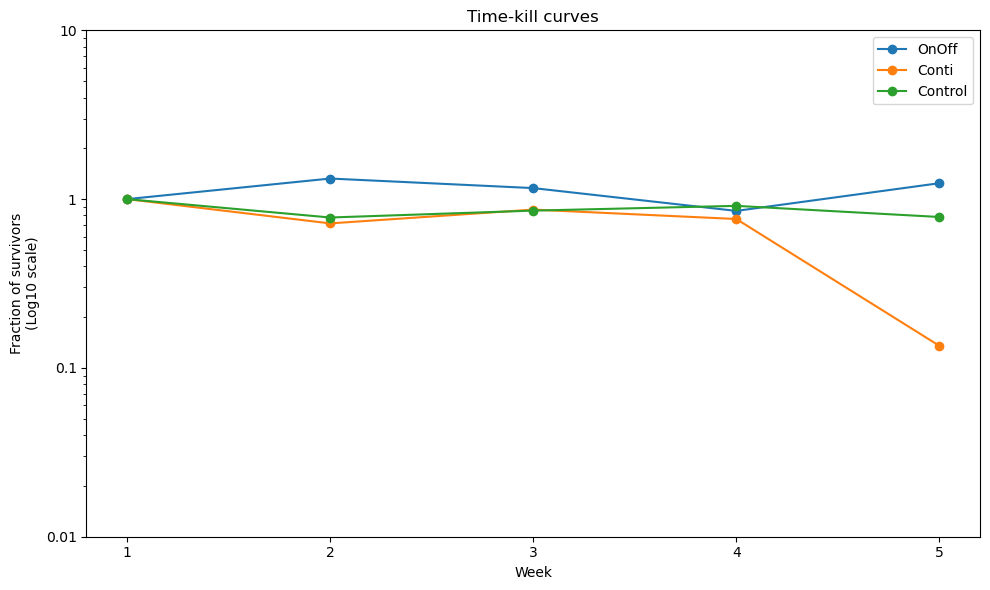

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

treatments = adata.obs['treatment'].unique()

for treatment in reversed(treatments):
    adata_subset = adata[adata.obs['treatment'] == treatment]
    cell_counts = adata_subset.obs.groupby("week", observed=True).size()
    week_1_count = cell_counts.loc["1"]
    survival_rate = cell_counts / week_1_count
    ax.plot(survival_rate.index, survival_rate.values, marker="o", linestyle="-", label=treatment)

ax.set_xlabel("Week")
ax.set_ylabel("Fraction of survivors\n(Log10 scale)")
ax.set_title("Time-kill curves")
ax.set_yscale("log")
ax.legend()

# Set y-axis ticks
yticks = [0.01, 0.1, 1, 10]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

plt.tight_layout()
plt.show()

Growth after week 4 in OnOff --> from tolerance to persistance?

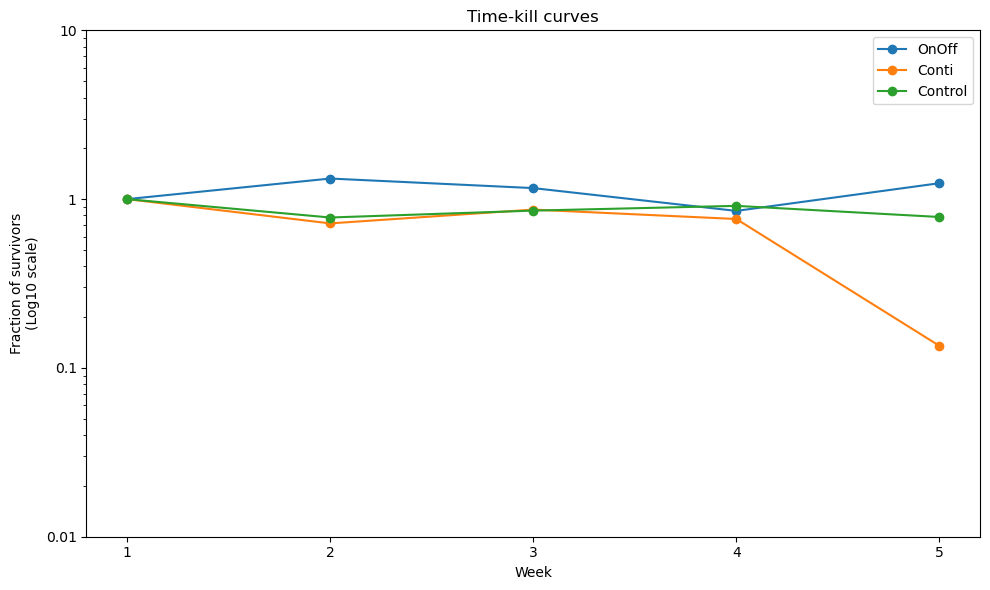

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for treatment in reversed(adata.obs['treatment'].unique()):
    adata_subset = adata[adata.obs['treatment'] == treatment]
    cell_counts = adata_subset.obs.groupby("week", observed=True).size()
    week_1_count = cell_counts.loc["1"]
    survival_rate = cell_counts / week_1_count
    ax.plot(survival_rate.index, survival_rate.values, marker="o", linestyle="-", label=treatment)

ax.set_xlabel("Week")
ax.set_ylabel("Fraction of survivors\n(Log10 scale)")
ax.set_title("Time-kill curves")
ax.set_yscale("log")
ax.legend()

# Set y-axis ticks
yticks = [0.01, 0.1, 1, 10]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

plt.tight_layout()
plt.show()

## Could the per sample filtering have influenced the results and explain why OnOff increases from week 1 to 2?
Is it important? After all, we do not have replicates, and the same happened with replicates (!) in the original paper.

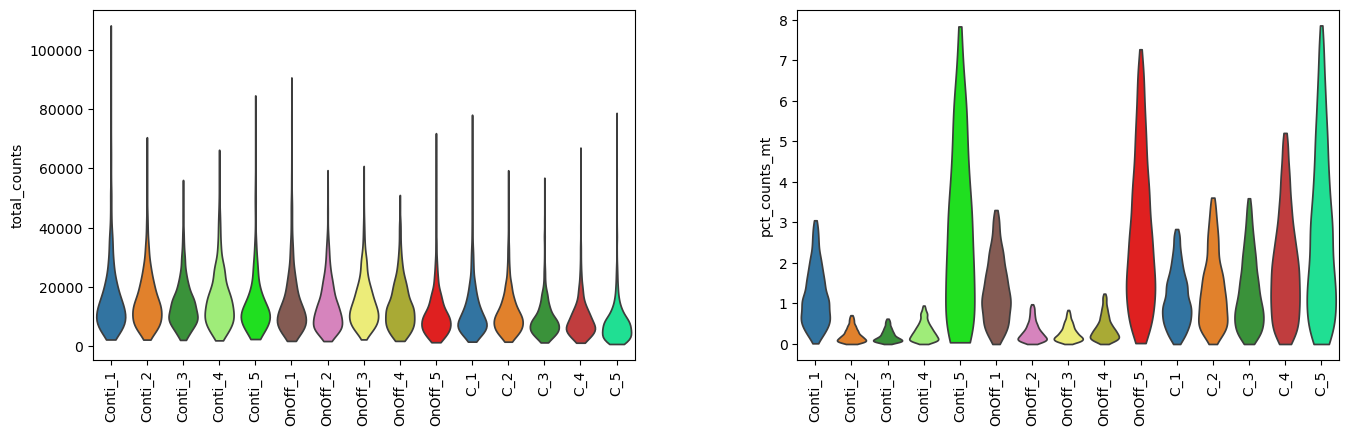

In [224]:
sc.pl.violin(adata, keys=['total_counts','pct_counts_mt'], groupby='sample', stripplot=False, rotation=90)

# Cell counts per cluster (time-kill curves are not appropriate in this case)

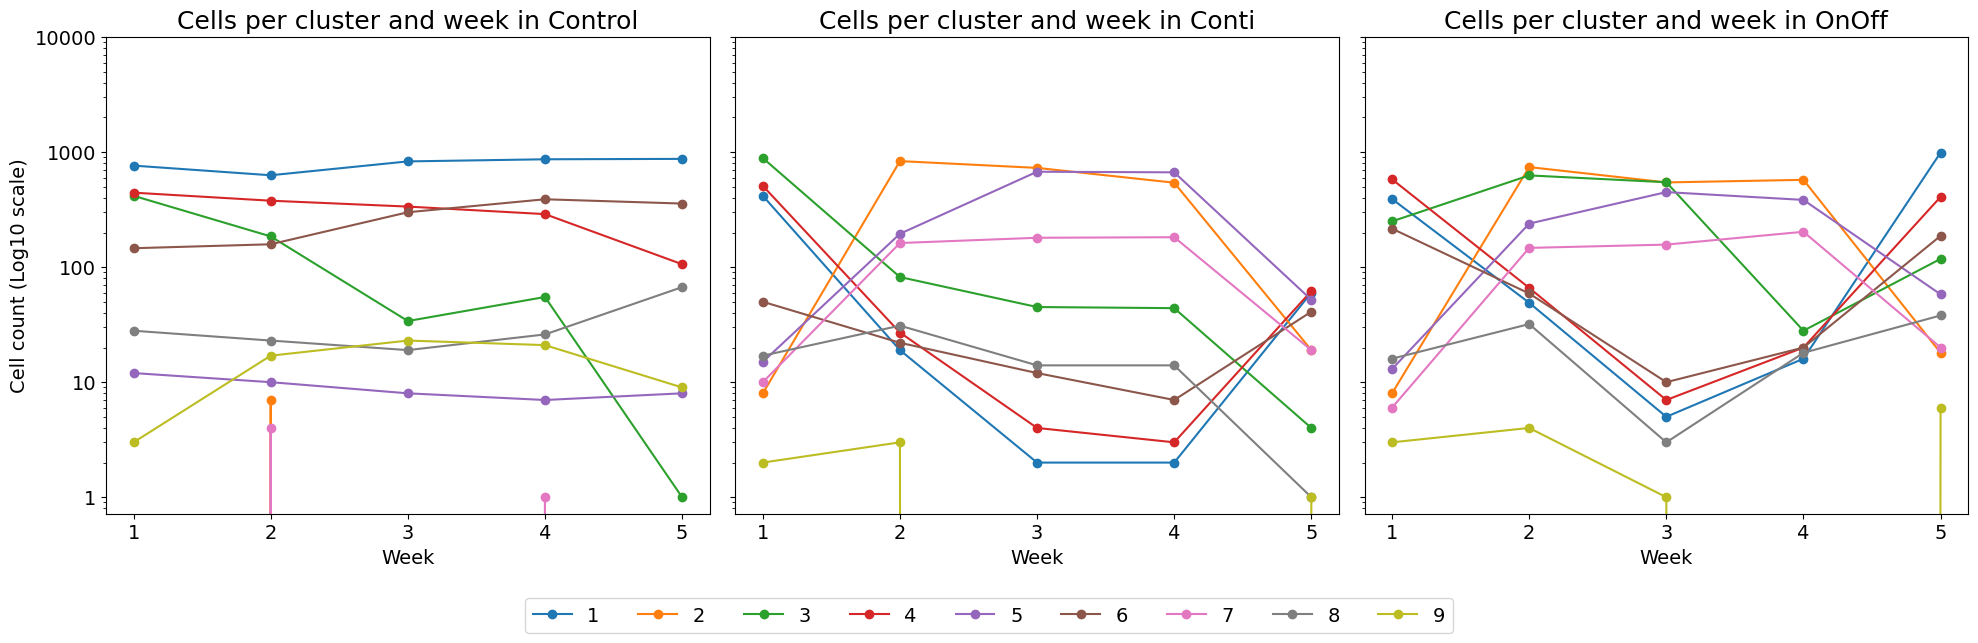

In [284]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(treatments), figsize=(20, 6), sharey=True)

for ax, treatment in zip(axes, treatments):
    adata_subset2 = adata[adata.obs['treatment'] == treatment]
    
    for cluster in sorted(adata_subset2.obs['clusters'].unique()):
        adata_subset = adata_subset2[adata_subset2.obs['clusters'] == cluster]
        cell_counts = adata_subset.obs.groupby("week", observed=True).size()
        # Ensure all weeks are present in cell_counts, adding 0 count for missing weeks
        all_weeks = adata_subset2.obs['week'].unique()
        for week in all_weeks:
            if week not in cell_counts.index:
                cell_counts.loc[week] = 0

        cell_counts = cell_counts.sort_index()
        ax.plot(cell_counts.index, cell_counts.values, marker="o", linestyle="-", label=cluster)

    ax.set_xlabel("Week")
    ax.set_title(f"Cells per cluster and week in {treatment}")

axes[0].set_ylabel("Cell count (Log10 scale)")
axes[0].set_yscale("log")
# Set y-axis ticks
yticks = [1, 10, 100, 1000, 10000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), bbox_transform=plt.gcf().transFigure, ncol=len(handles))

plt.tight_layout()
plt.show()

Is there anything relevant / not just because of cell cycle phase?

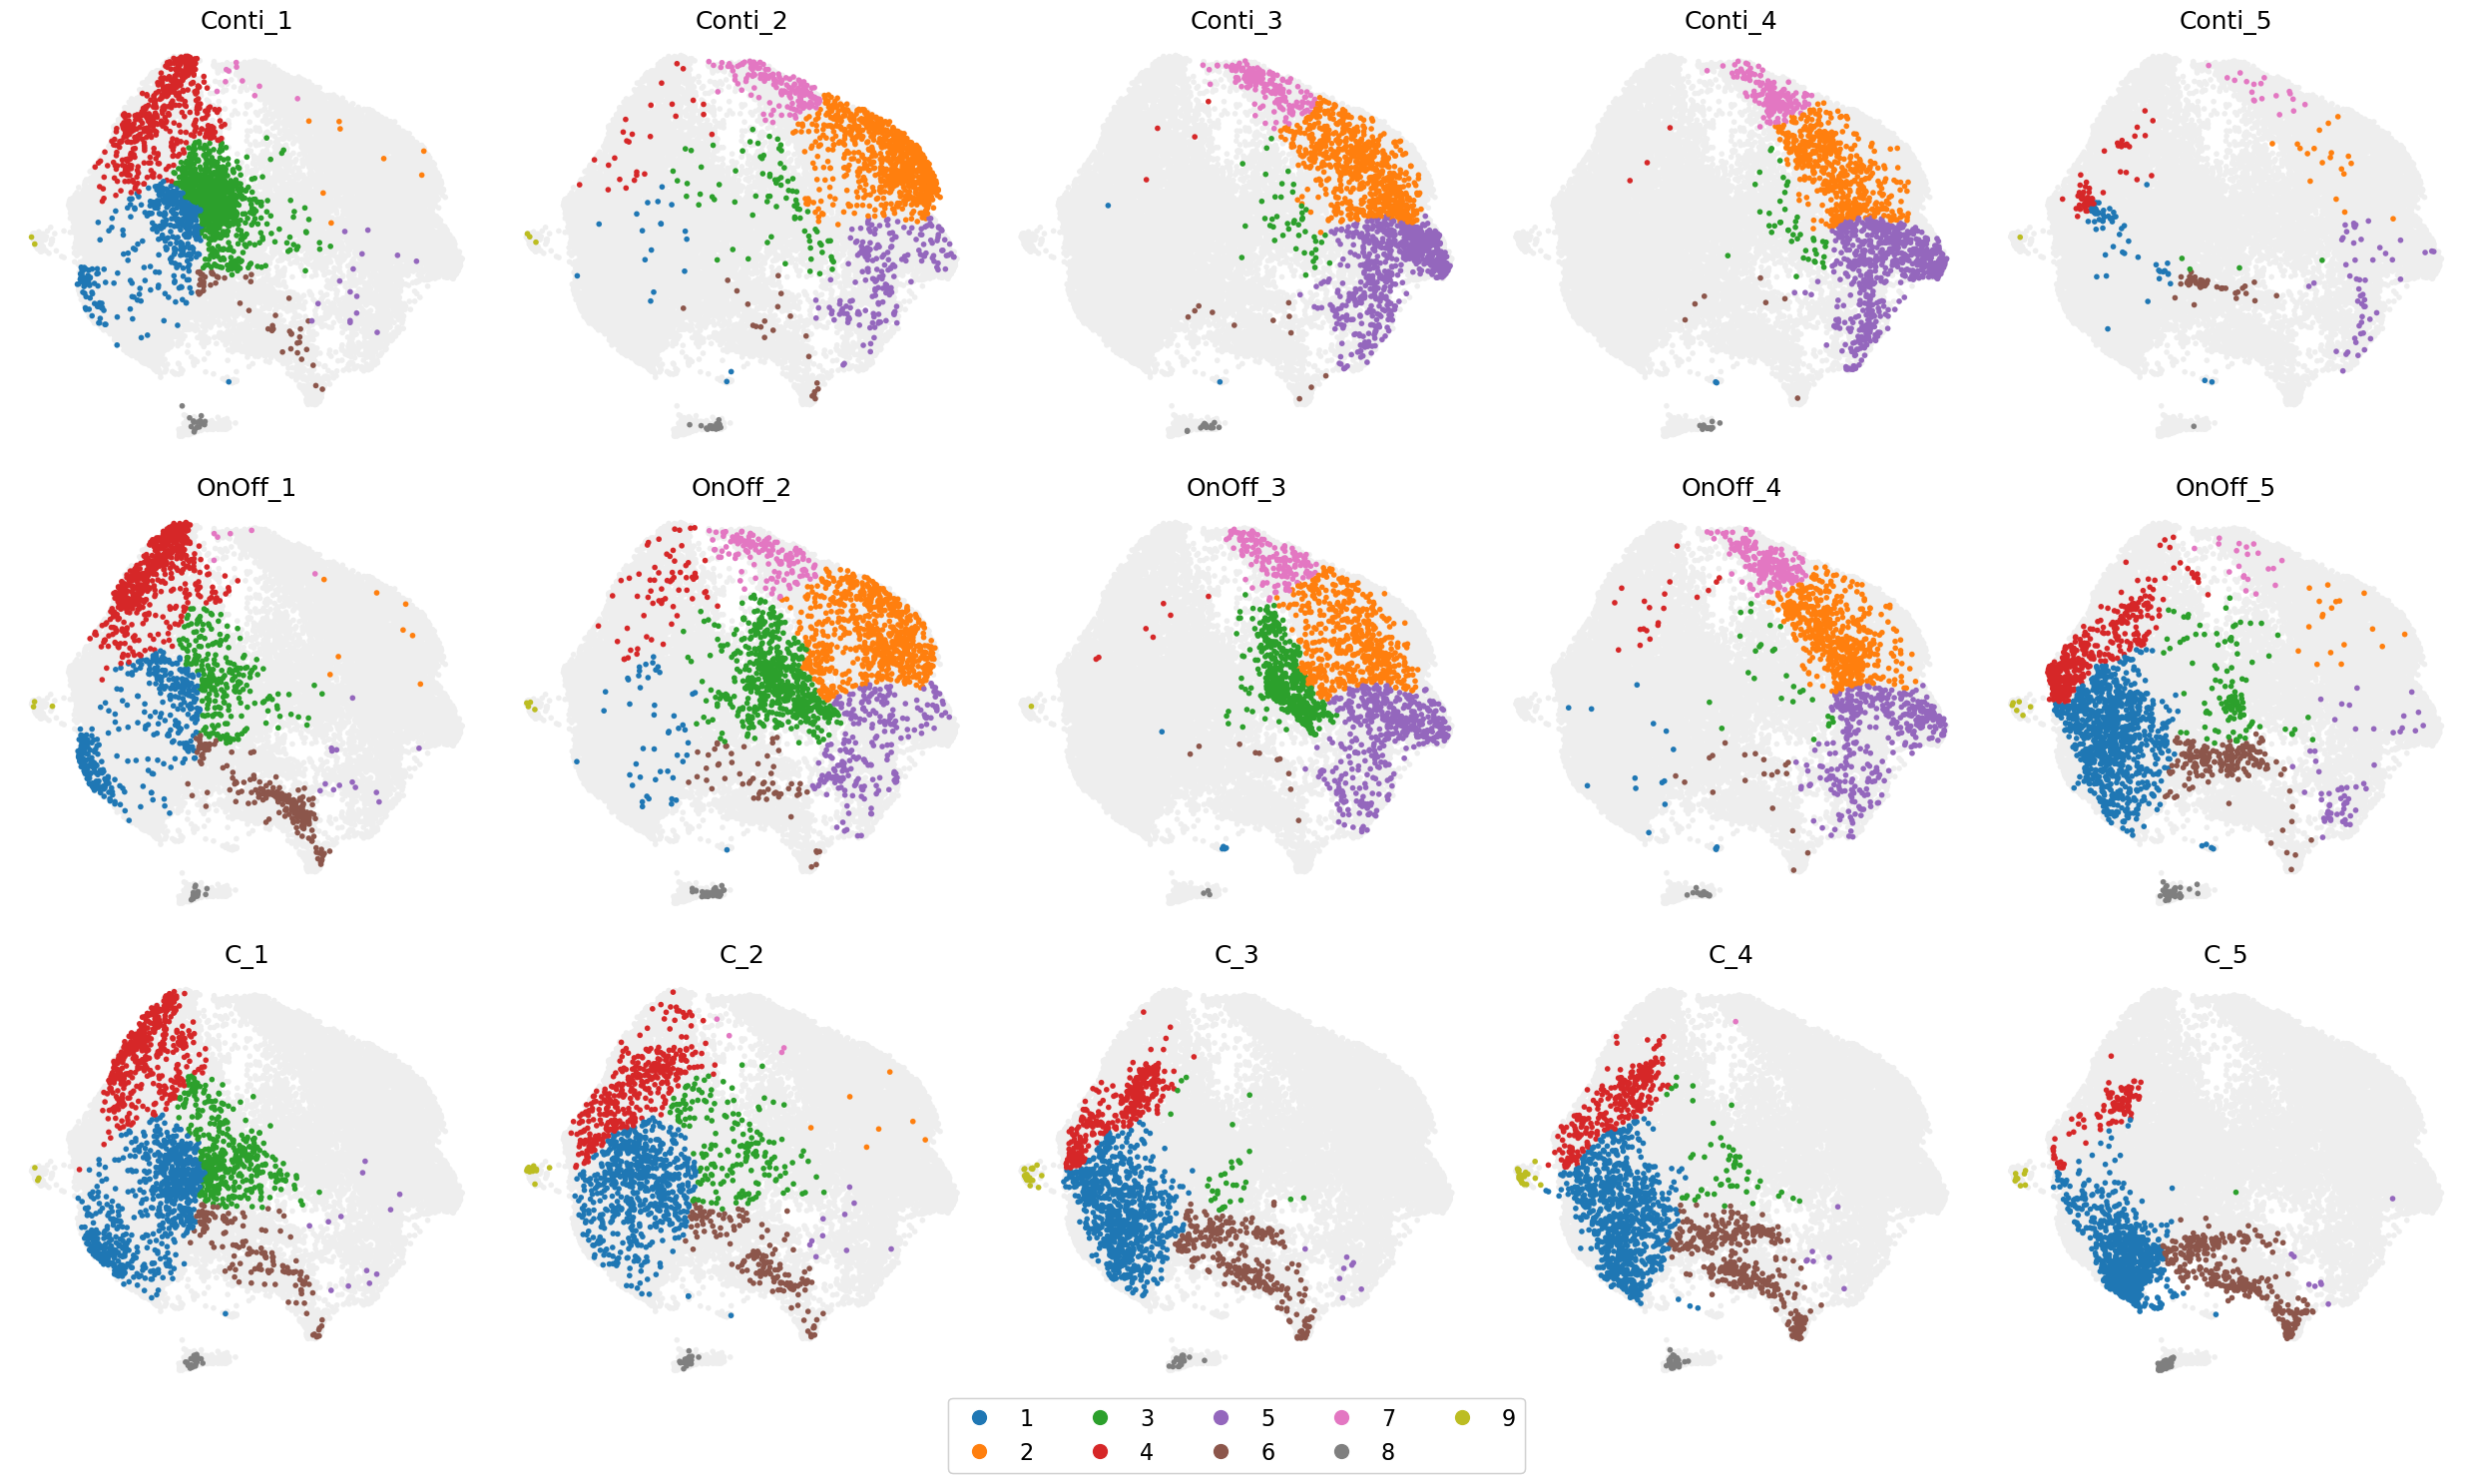

In [236]:
split_dim_plot(adata, "sample", embedding="umap", color="clusters", frameon=False)

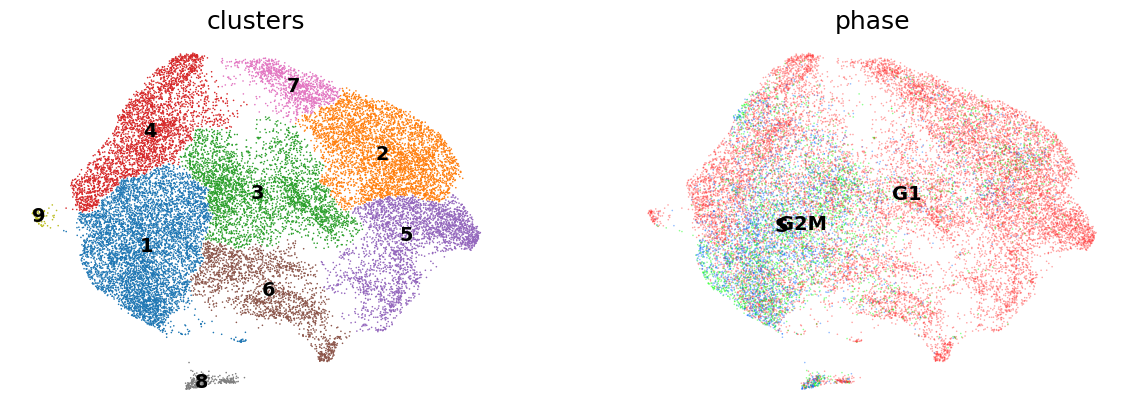

In [274]:
sc.pl.umap(adata, color=['clusters', 'phase'], legend_loc='on data', frameon=False, ncols=2)